In [259]:
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from mlxtend.data import loadlocal_mnist
from skimage.feature import hog
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Dataset Preparation

In [260]:
# Process dataset
train_images, train_labels = loadlocal_mnist(images_path='mnist-dataset/emnist-letters-train-images-idx3-ubyte',
                                             labels_path='mnist-dataset/emnist-letters-train-labels-idx1-ubyte')

In [261]:
print("Number of images:", len(train_images))
print("Number of labels:", len(train_labels))
print("Image shape:", train_images.shape)
print("Label shape:", train_labels.shape)

Number of images: 124800
Number of labels: 124800
Image shape: (124800, 784)
Label shape: (124800,)


#### Use Preprocessing for Dataset

In [262]:
# Use 2600 samples only for this exam
X_selected = []
y_selected = []

for class_id in range(1, 27):
    idx = np.where(train_labels == class_id)[0][:100] 
    X_selected.append(train_images[idx])
    y_selected.append(train_labels[idx])

X_selected = np.vstack(X_selected)
y_selected = np.hstack(y_selected)

print(X_selected.shape)
print(y_selected.shape)


(2600, 784)
(2600,)


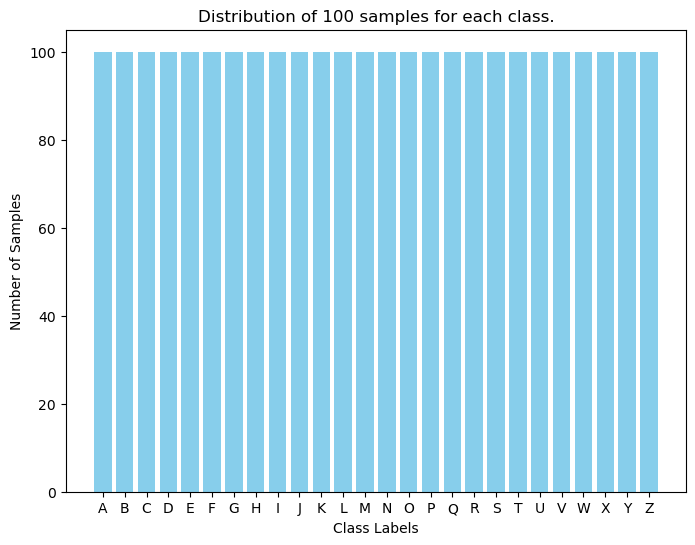

In [263]:
unique_classes, counts = np.unique(y_selected, return_counts=True)

# Plotting the class counts
plt.figure(figsize=(8, 6))
plt.bar(unique_classes, counts, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Distribution of 100 samples for each class.')
plt.xticks(unique_classes, [chr(label + 64) for label in unique_classes])
plt.show()

In [264]:
# Shuffle datasets before processing
X_selected, y_selected = shuffle(X_selected, y_selected, random_state=42)


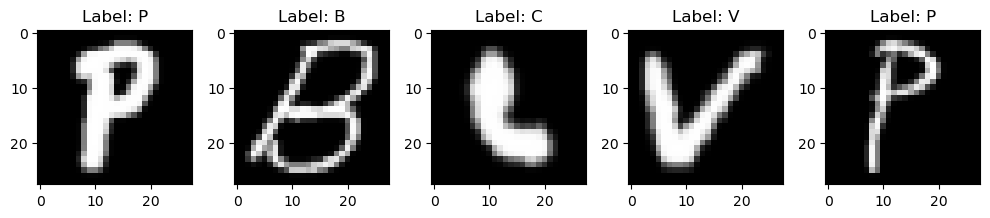

In [265]:
# visualize the image
plt.figure(figsize=(10, 4))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_selected[i].reshape(28, 28).T, cmap='gray') 
    plt.title(f"Label: {chr(y_selected[i] + 64)}") 
    plt.axis('on')

plt.tight_layout()
plt.show()

### Use HOG Feature Extraction

Change the default parameters
* orientations: default: 9 
* pixels_per_cell: default: (8, 8)
* cells_per_block: default: (3, 3)

In [266]:
feature, hog_img = hog(X_selected[1].reshape(28,28), orientations=12, pixels_per_cell=(6, 6), cells_per_block=(2,2), visualize=True, block_norm='L2')
feature.shape

(432,)

<BarContainer object of 432 artists>

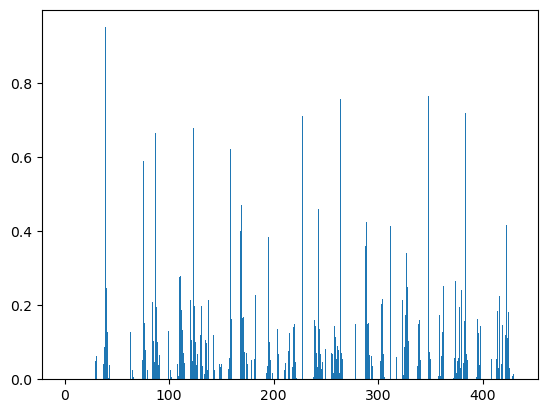

In [267]:
plt.bar(list(range(feature.shape[0])), feature)

#### HOG Visualization with Different Parameters

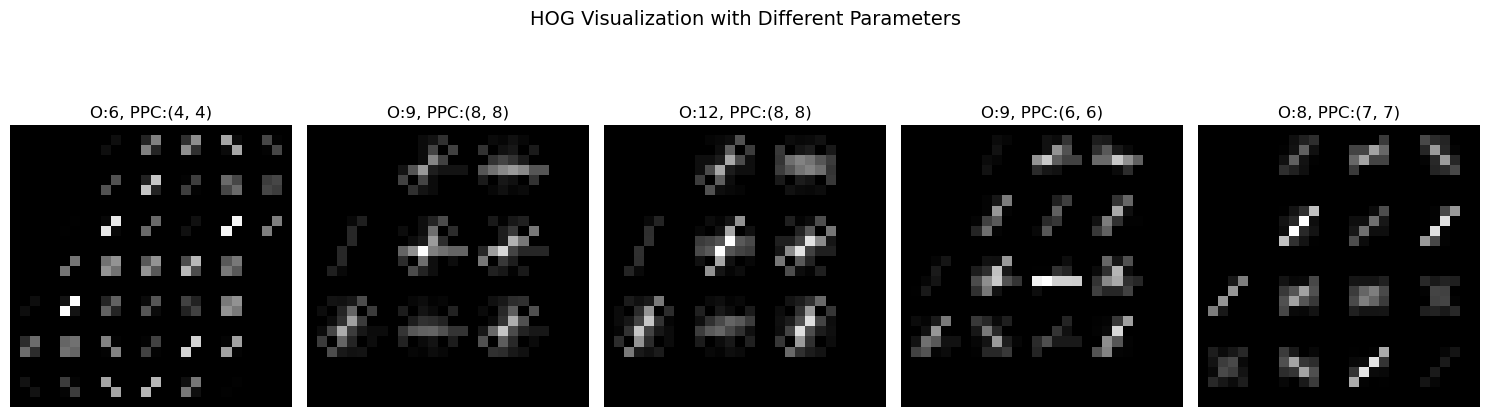

In [268]:
# Example image from dataset, reshaped and transposed
img = X_selected[1].reshape(28, 28).T

# Different sets of HOG parameters to test
param_sets = [
    {"orientations": 6, "pixels_per_cell": (4, 4), "cells_per_block": (2, 2)},
    {"orientations": 9, "pixels_per_cell": (8, 8), "cells_per_block": (2, 2)},
    {"orientations": 12, "pixels_per_cell": (8, 8), "cells_per_block": (3, 3)},
    {"orientations": 9, "pixels_per_cell": (6, 6), "cells_per_block": (2, 2)},
    {"orientations": 8, "pixels_per_cell": (7, 7), "cells_per_block": (2, 2)},
]

plt.figure(figsize=(15, 5))

# Generate and display HOG visualizations for each parameter set
for i, params in enumerate(param_sets):
    features, hog_image = hog(
        img,
        visualize=True,
        block_norm='L2',
        **params
    )
    
    plt.subplot(1, len(param_sets), i + 1)
    plt.imshow(hog_image, cmap='gray')
    plt.title(f"O:{params['orientations']}, PPC:{params['pixels_per_cell']}")
    plt.axis('off')

plt.suptitle("HOG Visualization with Different Parameters", fontsize=14)
plt.tight_layout()
plt.show()

#### Preprocessing using HOG Feature Extraction

In [269]:
# Modified HOG parameters
hog_params = {
    'orientations': 12,
    'pixels_per_cell': (6, 6),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys'
}

# Extract HOG features from the dataset
def extract_hog_features(images, hog_params):
    features = []
    for img in images:
        img_reshaped = img.reshape(28, 28).T  
        hog_feat = hog(img_reshaped, **hog_params)
        features.append(hog_feat)
    return np.array(features)

X_hog = extract_hog_features(X_selected, hog_params)

print(X_hog.shape)


(2600, 432)


### Use Support Vector Machine (SVM) for Classification

#### Use GridSearchCV to find best parameter for SVM

In [270]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

X_tune = X_hog
y_tune = y_selected

# Hyperparameter options to test during tuning
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Create SVM model instance
svm = SVC()

# Use GridSearchCV with 3-fold CV to find the best hyperparameters
grid_search = GridSearchCV(svm, param_grid, cv=3, verbose=2, n_jobs=1)
grid_search.fit(X_tune, y_tune)

# Output the best found hyperparameters
print("\nBest Parameters from Grid Search:", grid_search.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.1s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.4s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.4s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.4s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   1.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   1.0s
[CV] END ......................C=0.1, gamma=auto

#### Evaluate on train (80%) and test datasets (20%)

In [271]:
# Split the dataset into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_tune, y_tune, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)

X_train shape: (2080, 432)
X_test shape : (520, 432)
y_train shape: (2080,)
y_test shape : (520,)


### Use Leave-One-Out-Cross-Validation Evaluation

In [272]:
# Initialize LeaveOneOut on training data (80%)
loo = LeaveOneOut()

# Store all true labels and predictions
y_true_all = []
y_pred_all = []

# Iterate over each split in the training data
for train_index, test_index in tqdm(loo.split(X_train), total=len(X_train)):
    # Get training and test data based on indices
    X_train_loo, X_test_loo = X_train[train_index], X_train[test_index]
    y_train_loo, y_test_loo = y_train[train_index], y_train[test_index]
    
    # Train the SVM model (Support Vector Classification)
    model = SVC(**grid_search.best_params_)
    model.fit(X_train_loo, y_train_loo)
    
    # Test the model on the remaining test data
    y_pred = model.predict(X_test_loo)
    y_true_all.append(y_test_loo[0])
    y_pred_all.append(y_pred[0])

100%|██████████| 2080/2080 [26:50<00:00,  1.29it/s]


In [273]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Overall results
print("\n=== LOOCV Evaluation Results ===")
print("LOOCV Accuracy: {:.2f}%".format(accuracy_score(y_true_all, y_pred_all) * 100))
print("Precision: {:.2f}%".format(precision_score(y_true_all, y_pred_all, average='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(y_true_all, y_pred_all, average='weighted') * 100))
print("F1 Score: {:.2f}%".format(f1_score(y_true_all, y_pred_all, average='weighted') * 100))

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=[chr(i+64) for i in range(1, 27)]))


=== LOOCV Evaluation Results ===
LOOCV Accuracy: 81.68%
Precision: 82.04%
Recall: 81.68%
F1 Score: 81.72%
Classification Report:
              precision    recall  f1-score   support

           A       0.65      0.76      0.70        79
           B       0.83      0.76      0.79        82
           C       0.78      0.80      0.79        79
           D       0.85      0.90      0.87        81
           E       0.79      0.86      0.82        79
           F       0.91      0.91      0.91        66
           G       0.74      0.64      0.69        76
           H       0.77      0.91      0.84        81
           I       0.54      0.61      0.57        82
           J       0.87      0.87      0.87        84
           K       0.96      0.84      0.89        81
           L       0.59      0.54      0.57        81
           M       0.93      0.79      0.86        82
           N       0.76      0.81      0.78        83
           O       0.89      0.93      0.91        82
     

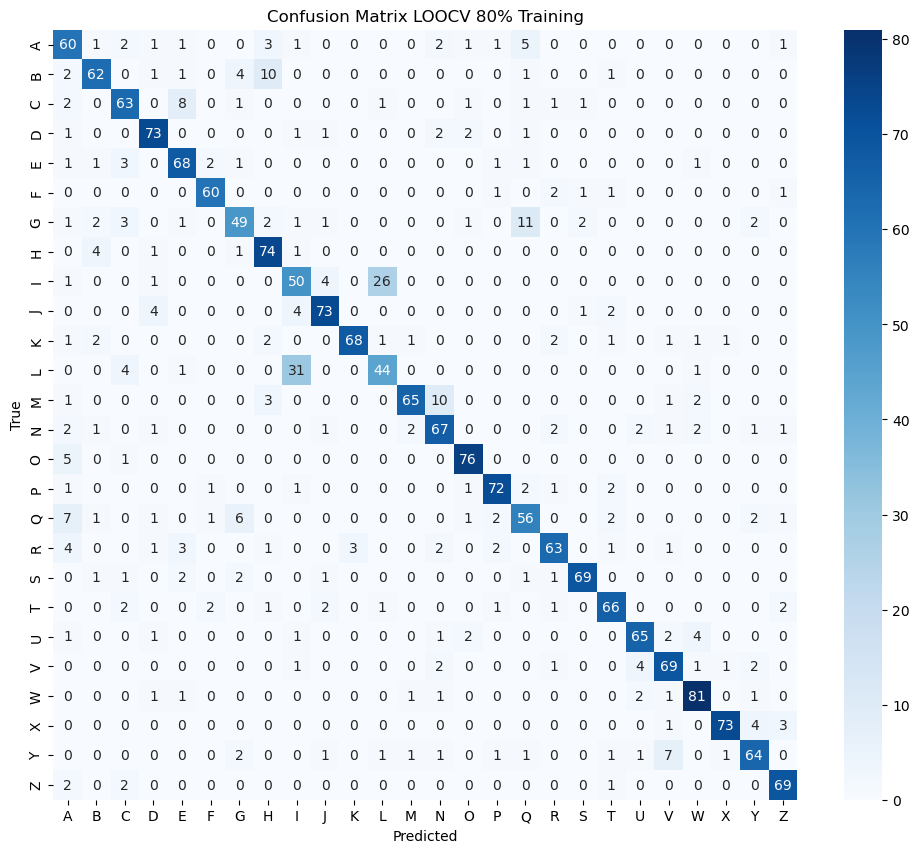

In [274]:
# Compute confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Create labels from ASCII codes (A, B, C, ...)
labels = [chr(i) for i in range(65, 65 + cm.shape[0])] 

plt.figure(figsize=(12, 10))
# Plot confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix LOOCV 80% Training")
plt.show()


### Use 20% from dataset to Evaluation

In [275]:
# Train the model on the previously split 20% training data
model.fit(X_train, y_train)
# Evaluate accuracy on the 20% test data
test_accuracy = model.score(X_test, y_test)

# Predict labels for the test data
y_pred = model.predict(X_test)

print("\n=== LOOCV Evaluation Results ===")
print("Test set accuracy: {:.2f}%".format(test_accuracy * 100))
print("Precision: {:.2f}%".format(precision_score(y_test, y_pred, average='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(y_test, y_pred, average='weighted') * 100))
print("F1 Score: {:.2f}%".format(f1_score(y_test, y_pred, average='weighted') * 100))

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[chr(i+64) for i in range(1, 27)]))



=== LOOCV Evaluation Results ===
Test set accuracy: 80.96%
Precision: 81.86%
Recall: 80.96%
F1 Score: 80.81%
Classification Report:
              precision    recall  f1-score   support

           A       0.57      0.57      0.57        21
           B       0.73      0.89      0.80        18
           C       0.84      1.00      0.91        21
           D       0.92      0.63      0.75        19
           E       0.94      0.81      0.87        21
           F       0.88      0.82      0.85        34
           G       0.76      0.54      0.63        24
           H       0.94      0.79      0.86        19
           I       0.52      0.61      0.56        18
           J       0.67      0.88      0.76        16
           K       0.95      1.00      0.97        19
           L       0.79      0.58      0.67        19
           M       0.80      0.89      0.84        18
           N       0.71      0.59      0.65        17
           O       0.89      0.89      0.89        18
  

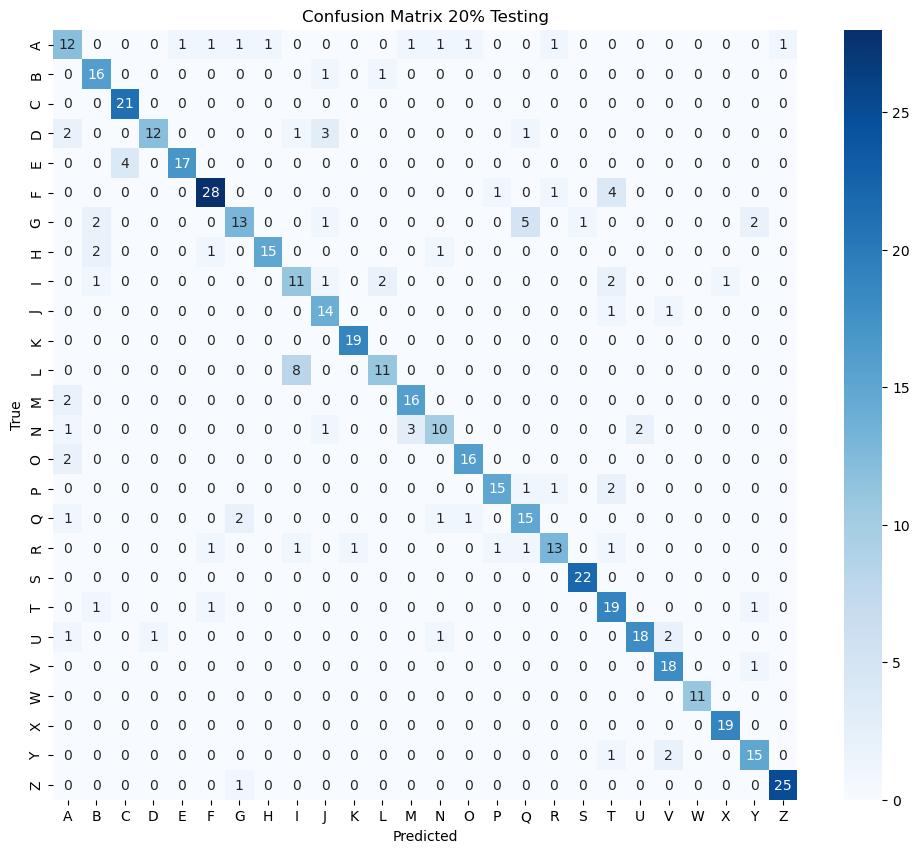

In [276]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create labels from ASCII codes (A, B, C, ...)
labels = [chr(i) for i in range(65, 65 + cm.shape[0])] 

plt.figure(figsize=(12, 10))
# Plot confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix 20% Testing")
plt.show()